In [8]:
from BaseEnv import BaseClass
import tensorflow as tf
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Dropout, TimeDistributed, BatchNormalization
from tensorflow.keras.models import Sequential
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [9]:
class RNNClass(BaseClass):

    def __init__(self,
        feature_steps: int = 10,
        target_steps: int = 1,
        batchnormalization: bool = False,
        layers_RNN: int = 2,
        layers_LSTM: int = 2
    ):  
        super().__init__(feature_steps = feature_steps, target_steps = target_steps)
        self.models = {}
        self.bn = batchnormalization
        self.layers = {SimpleRNN: layers_RNN, LSTM: layers_LSTM}
        self.models_function_name = {SimpleRNN: self.rnn_dense_model, LSTM: self.lstm_model}
        self.models_name_str = {SimpleRNN: "SimpleRNN", LSTM: "LSTM"}
        self.train_series = {}
        self.train_pred = {}
        self.valid_pred = {}
        self.test_pred = {}
        self.train_errors = {}
        self.valid_errors = {}
        self.test_errors = {}
        self.test_dates = {}
        self.history = {}
        for t in self.tickers:
            self.train_series[t] = np.concatenate( (self.y_train[t],self.y_valid[t],self.y_test[t]), axis=0)
            self.models[t] = dict()
            self.train_pred[t] = {SimpleRNN: [], LSTM: []}
            self.valid_pred[t] = {SimpleRNN: [], LSTM: []}
            self.test_pred[t] = {SimpleRNN: [], LSTM: []}
            self.train_errors[t] = {SimpleRNN: [], LSTM: []}
            self.valid_errors[t] = {SimpleRNN: [], LSTM: []}
            self.test_errors[t] = {SimpleRNN: [], LSTM: []}
            self.test_dates[t] = {SimpleRNN: [], LSTM: []}
            self.history[t] = {}

    def Prediction(self,
        model
    ):
        for t in self.tickers:
            self.reset_session()
            n_train = len(self.X_train[t])
            n_valid = len(self.X_valid[t])
            n_test = len(self.X_test[t])

            input_shape = (self.X_train[t].shape[1], 4)
            output_units = self.y_train[t].shape[1] if len(self.y_train[t].shape) > 1 else 1

            if model in [SimpleRNN, LSTM]:
                m = self.models_function_name[model](input_shape=input_shape, output_units=output_units, layers = self.layers[model])
                m.compile(loss="mse", optimizer="nadam")
            else:
                raise TypeError("model must be SimpleRNN or LSTM")
            

            early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=200,
                                                              min_delta=0.01,
                                                              restore_best_weights=True)
            
            m.summary()

            self.history[t][model] = m.fit(self.X_train[t][..., np.newaxis], self.y_train[t][..., np.newaxis], epochs=50,
                                              validation_data=(self.X_valid[t][..., np.newaxis], self.y_valid[t][..., np.newaxis]),
                                              callbacks=[early_stopping_cb], verbose=0)

            #pd.DataFrame(run.history).iloc[-11:]

            self.train_pred[t][model] = m.predict(self.X_train[t])
            self.valid_pred[t][model] = m.predict(self.X_valid[t])
            self.test_pred[t][model] = m.predict(self.X_test[t])

            self.train_errors[t][model] = mean_squared_error(self.y_train[t], self.train_pred[t][model])
            self.valid_errors[t][model] = mean_squared_error(self.y_valid[t], self.valid_pred[t][model])
            self.test_errors[t][model] = mean_squared_error(self.y_test[t], self.test_pred[t][model])

            self.test_dates[t][model] = self.dates[t][-n_test:]

            self.models[t][model] = m

    def rnn_dense_model(self,
        input_shape,
        output_units,
        layers
    ):
        model = Sequential()
        
        for i in range(layers):
            model.add(SimpleRNN(units=64, activation='relu', input_shape=input_shape, return_sequences=True))
            model.add(Dropout(0.2))        

            model.add(TimeDistributed(Dense(units=32, activation='relu')))

        model.add(SimpleRNN(units=64, activation='relu', return_sequences=False))
        model.add(Dropout(0.2))
        
        model.add(Dense(units=64, activation='relu'))

        if self.bn:
            model.add(BatchNormalization())

        model.add(Dense(units=32, activation='relu'))
        
        model.add(Dense(units=output_units))
        return model

    def lstm_model(self,
        input_shape,
        output_units,
        layers
    ):
        model = Sequential()

        for i in range(layers):
            model.add(LSTM(units=64, input_shape=input_shape, return_sequences=True))
            model.add(Dropout(0.2))
        
        model.add(LSTM(units=64, return_sequences=False))
        
        model.add(Dense(units=output_units))
        
        return model

    def reset_session(self,
            seed=42
        ):
            tf.random.set_seed(seed)
            np.random.seed(seed)
            tf.keras.backend.clear_session()

    def VisualizationRNN(self,
        model,
        plot: bool = False,
        logdiff: bool = True
    ):
        if model not in [SimpleRNN,LSTM]:
            raise TypeError("model must be SimpleRNN or LSTM")
        else:
            self.Visualization(model=model,plot=plot,logdiff=logdiff)

In [10]:
ModelRNN = RNNClass()

for m in [SimpleRNN,LSTM]:
    ModelRNN.Prediction(m)

c:\Users\yoshi\anaconda3\envs\SimulatingScenarios\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 10, 64)         │         4,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 10, 32)         │         2,080 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 10, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 10, 32)         │         2,080 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 64)             │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,364 (106.89 KB)

 Trainable params: 27,364 (106.89 KB)

 Non-trainable params: 0 (0.00 B)

66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


c:\Users\yoshi\anaconda3\envs\SimulatingScenarios\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 64)         │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,972 (328.02 KB)

 Trainable params: 83,972 (328.02 KB)

 Non-trainable params: 0 (0.00 B)

66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[datetime.datetime(2018, 5, 31, 0, 0), datetime.datetime(2018, 6, 1, 0, 0), datetime.datetime(2018, 6, 4, 0, 0), datetime.datetime(2018, 6, 5, 0, 0), datetime.datetime(2018, 6, 6, 0, 0), datetime.datetime(2018, 6, 7, 0, 0), datetime.datetime(2018, 6, 8, 0, 0), datetime.datetime(2018, 6, 11, 0, 0), datetime.datetime(2018, 6, 12, 0, 0), datetime.datetime(2018, 6, 13, 0, 0), datetime.datetime(2018, 6, 14, 0, 0), datetime.datetime(2018, 6, 15, 0, 0), datetime.datetime(2018, 6, 18, 0, 0), datetime.datetime(2018, 6, 19, 0, 0), datetime.datetime(2018, 6, 20, 0, 0), datetime.datetime(2018, 6, 21, 0, 0), datetime.datetime(2018, 6, 22, 0, 0), datetime.datetime(2018, 6, 25, 0, 0), datetime.datetime(2018, 6, 26, 0, 0), datetime.datetime(2018, 6, 27, 0, 0), datetime.datetime(2018, 6, 28, 0, 0), datetime.datetime(2018, 6, 29, 0, 0), datetime.datetime(2018, 7, 2, 0, 0), datetime.datetime(2018, 7, 3, 0, 0), datetime.datetime(2018, 7, 5, 0, 0), datetime.datetime(2018, 7, 6, 0, 0), datetime.datetime(201

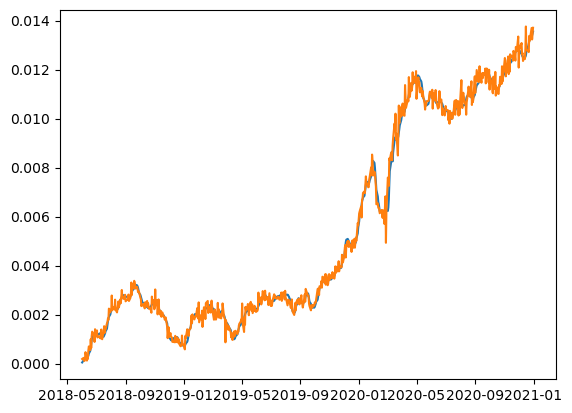

array([[1.        , 0.99793328],
       [0.99793328, 1.        ]])

In [61]:
k = list(ModelRNN.test_pred['aapl'].keys())

mod = 1
var = 0

pred = ModelRNN.test_pred['aapl'][k[mod]][:,var]
test = ModelRNN.y_test['aapl'][:,var]

print(ModelRNN.test_dates['aapl'][k[mod]])

pred_full = np.cumsum(pred)
test_full = pred_full[1:]+test[:-1]
pred_full = pred_full[:-1]
fig, ax = plt.subplots()
ax.plot(ModelRNN.test_dates['aapl'][k[mod]][1:],pred_full)
ax.plot(ModelRNN.test_dates['aapl'][k[mod]][1:],test_full)
# Show the plot
plt.show()

np.corrcoef(test_full,pred_full)